# Zyfra Gold Ore Machine Learning Model

# Introduction: 

In this project we are creating a machine learning model for the company Zyfra. The company creates efficient solutions for heavy industry. The model will predict how much gold can be recovered from a gold ore. The model's goal is to aid the optimization of production and the elimination of unprofitable parameters.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")

In [60]:
train_df = pd.read_csv('/datasets/gold_recovery_train.csv')
test_df = pd.read_csv('/datasets/gold_recovery_test.csv')
full_df = pd.read_csv('/datasets/gold_recovery_full.csv')

## Data Preperation

In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [62]:
#creating a function for displaying the main information about datasets:
def info_df(df):
    print('DataFrame:')
    display(df.head())
    print('------------------------------------------------------------------------------------------')
    print('Info:')
    print('')
    print(df.info())
    print('------------------------------------------------------------------------------------------')
    print('Shape')
    print('')
    display(df.shape)

In [63]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [64]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


- Training dataset has 87 columns with 16,860 rows. There appears to be missing values in some columns.
- Test data set has 53 columns and 5853 rows. There appears to be missing values in some columns.
- Full dataset has 87 columns with 22,716 rows. There appears to be missing values in some columns.
- Each dataframe has the incorrect type for the `date` column.
- Our targets are `rougher.output.recovery` and `final.output.recovery`

## Check if Recovery is Calculated Correctly

In [65]:
def calc_recovery(c, f, t):
    recovery = ((c * (f - t)) / (f * (c - t))) * 100
    recovery[recovery < 0] = np.nan
    recovery[recovery > 100] = np.nan
    return recovery

In [66]:
train_df['rougher.output.calc'] = calc_recovery(train_df['rougher.output.concentrate_au'],
           train_df['rougher.input.feed_au'], train_df['rougher.output.tail_au'])

In [67]:
train_df[['rougher.output.recovery', 'rougher.output.calc']].head()

,rougher.output.recovery,rougher.output.calc
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [68]:
# fill na with 0 for MAE
train_df['rougher.output.recovery'].fillna(method='bfill', inplace=True)
train_df['rougher.output.calc'].fillna(method='bfill', inplace=True)

In [69]:
mean_absolute_error(train_df['rougher.output.recovery'], train_df['rougher.output.calc'])

9.371717847524153e-15

The MAE value being low confirms that the recovery calculations are correct.

## Analyzing features not in the Test Set

In [70]:
test_columns = test_df.columns
non_test_columns = full_df.drop(test_columns, axis=1)

In [71]:
test_df = test_df.merge(full_df[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                           how = 'left', on = 'date')

In [72]:
info_df(non_test_columns)

DataFrame:


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,8.547551,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,8.558743,...,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,8.603505,...,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,7.221879,...,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,9.089428,...,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448


------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 n

(22716, 34)

We are analyzing the out values of raw materials and other chemicals that have been obtained at various stages of raw material enrichment.

## Data Preprocessing

In [73]:
# date format change
full_df['date'] = pd.to_datetime(full_df['date'])
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [74]:
full_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [75]:
full_df.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

In [76]:
train_df = train_df[test_df.columns]
train_df.shape

(16860, 55)

In [77]:
train_df.isna().sum()

date                                             0
primary_cleaner.input.sulfate                 1307
primary_cleaner.input.depressant              1262
primary_cleaner.input.feed_size                  0
primary_cleaner.input.xanthate                 985
primary_cleaner.state.floatbank8_a_air          40
primary_cleaner.state.floatbank8_a_level        33
primary_cleaner.state.floatbank8_b_air          40
primary_cleaner.state.floatbank8_b_level        27
primary_cleaner.state.floatbank8_c_air          38
primary_cleaner.state.floatbank8_c_level        27
primary_cleaner.state.floatbank8_d_air          39
primary_cleaner.state.floatbank8_d_level        27
rougher.input.feed_ag                           82
rougher.input.feed_pb                          228
rougher.input.feed_rate                        513
rougher.input.feed_size                        417
rougher.input.feed_sol                         292
rougher.input.feed_au                           83
rougher.input.floatbank10_sulfa

In [78]:
test_df.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [79]:
train_df.fillna(method='bfill', inplace=True)
test_df.fillna(method='bfill', inplace=True)

In [80]:
train_df.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [81]:
test_df.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [82]:
print(train_df.shape, test_df.shape, sep=' | ')

(16860, 55) | (5856, 55)


Now we have datasets without missing values and aren't losing a large amount of data in the process. Let's continue to work with it and conduct analysis.

## Data Analysis

In [83]:
elements = {'gold': 'au', 'silver': 'ag', 'lead': 'pb'}
elements

{'gold': 'au', 'silver': 'ag', 'lead': 'pb'}

In [84]:
def concentrate(e):
    cols = ['rougher.input.feed_'+e, 'rougher.output.concentrate_'+e, 
            'primary_cleaner.output.concentrate_'+e, 'final.output.concentrate_'+e]
    concentrate = full_df[cols]  
    sns.displot(full_df[cols], 
            legend=True, 
            kde=True, 
            height=7.7, 
            aspect=1.5)
    plt.title('Concentration of ' + str(e).title() + ' on the different stages', fontsize=16)
    plt.figure(figsize=(12.8,8))
    plt.xticks(rotation=0)
    sns.boxplot(data=full_df[cols])

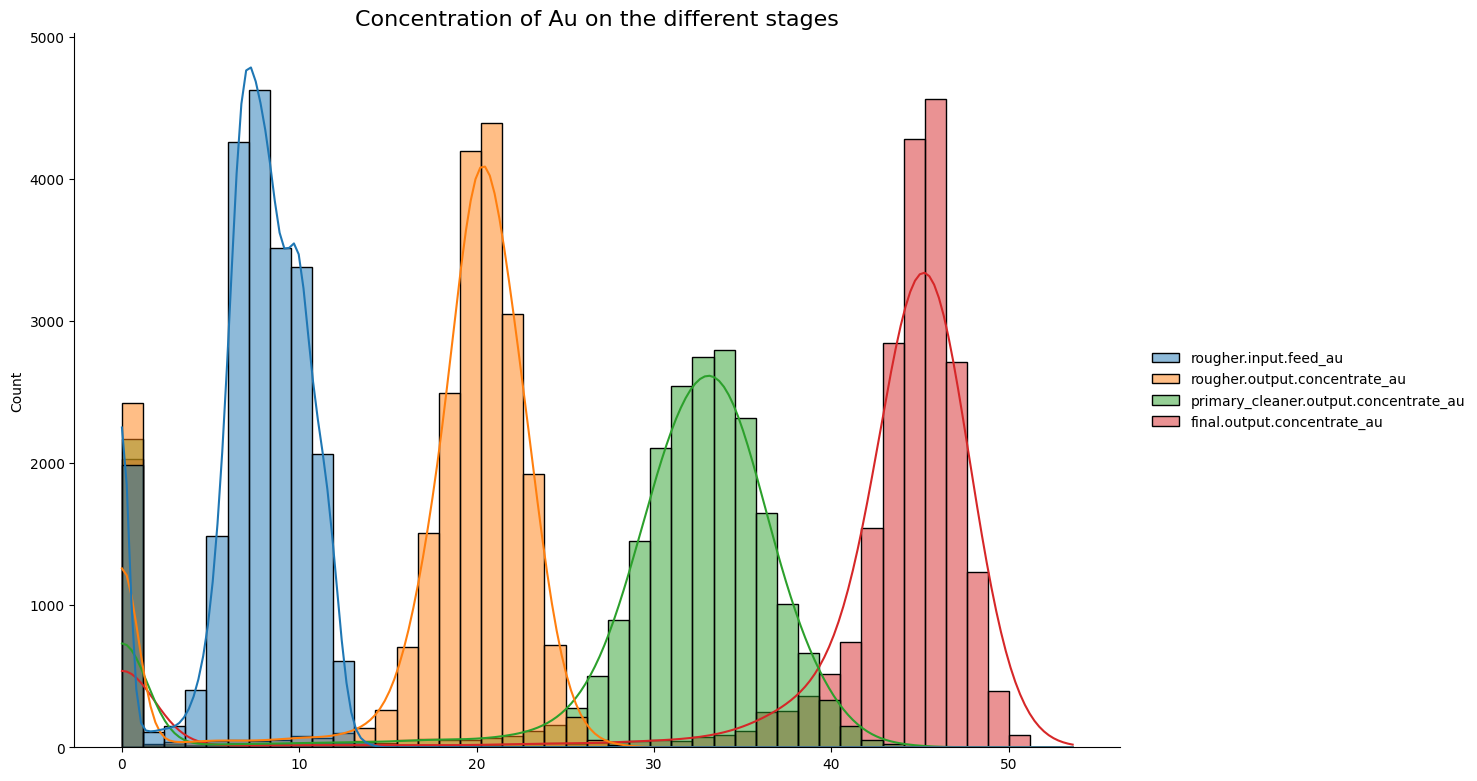

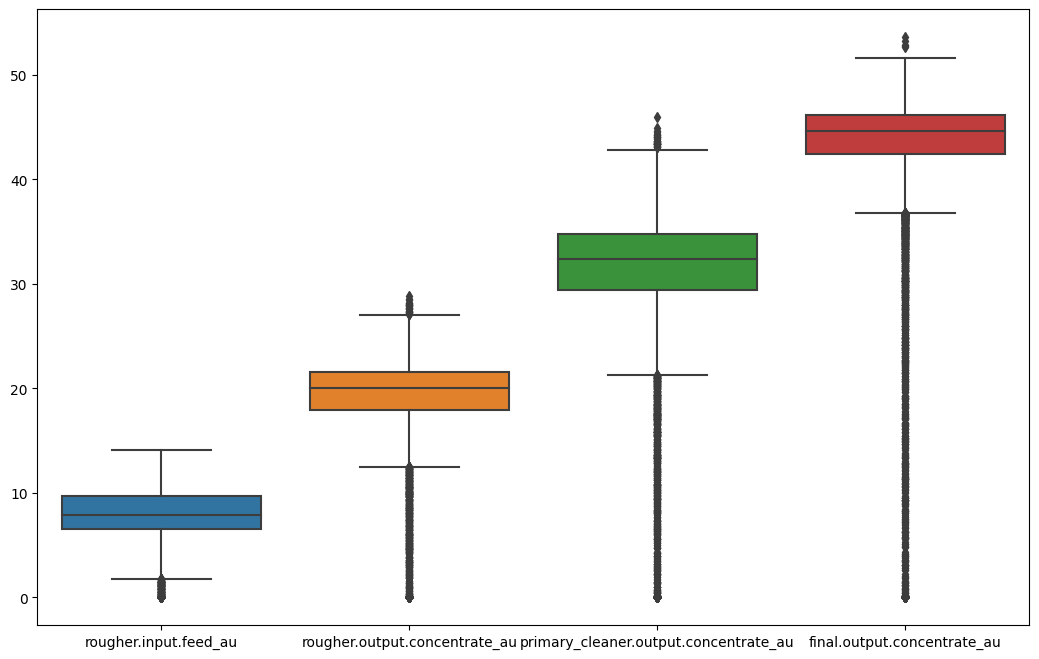

In [85]:
concentrate(elements['gold'])

We can see that the concentration of gold increases with each step. The boxplots shows there are outlier at each step.

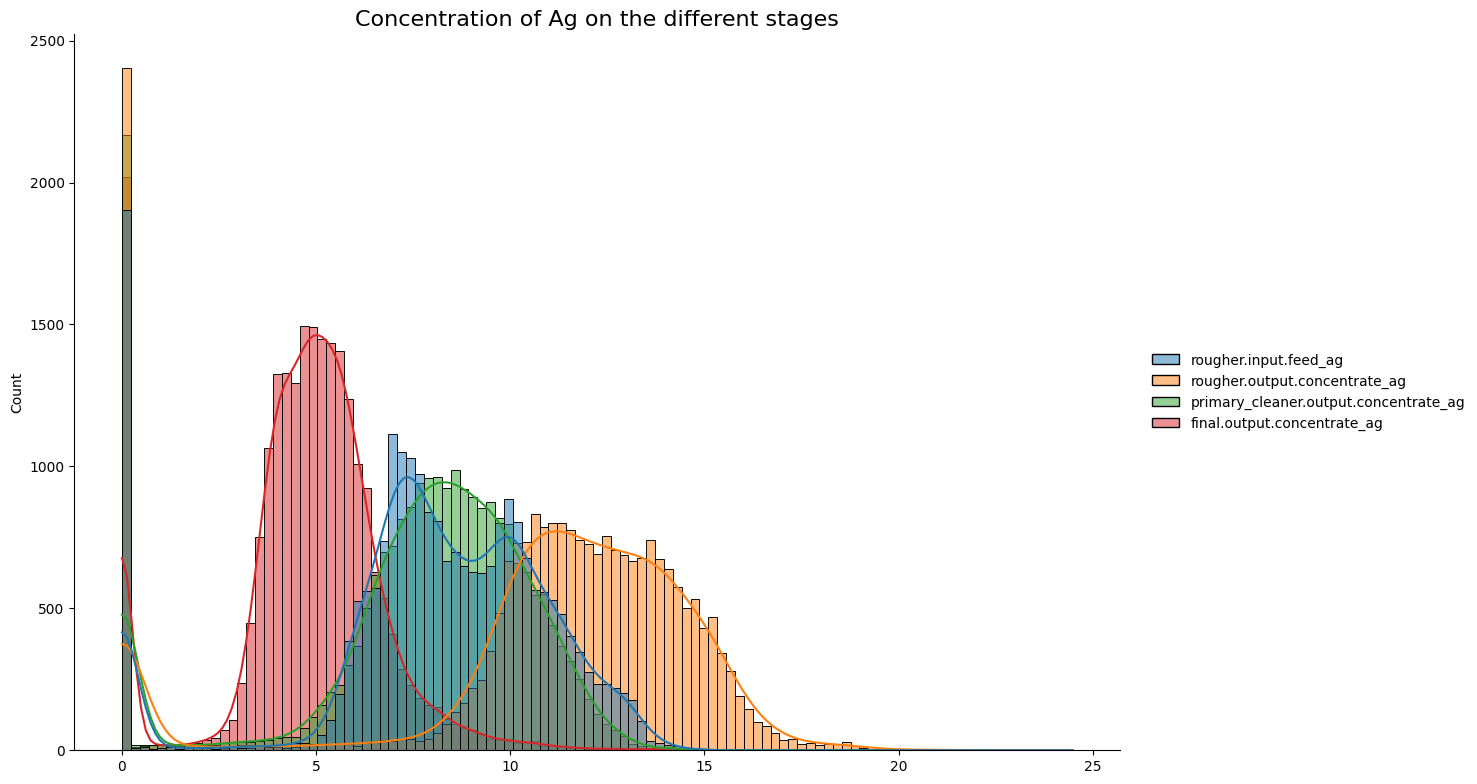

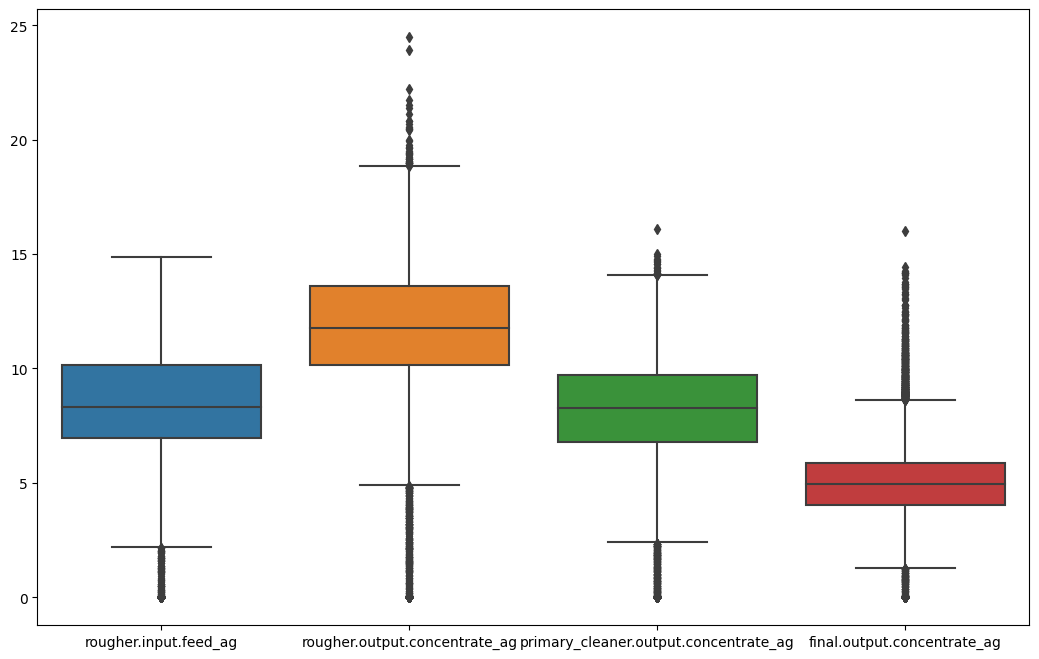

In [86]:
concentrate(elements['silver'])

With silver it looks like our distributions are decreasing at each stage. The boxplopts show that there are many outliers with this element as well.

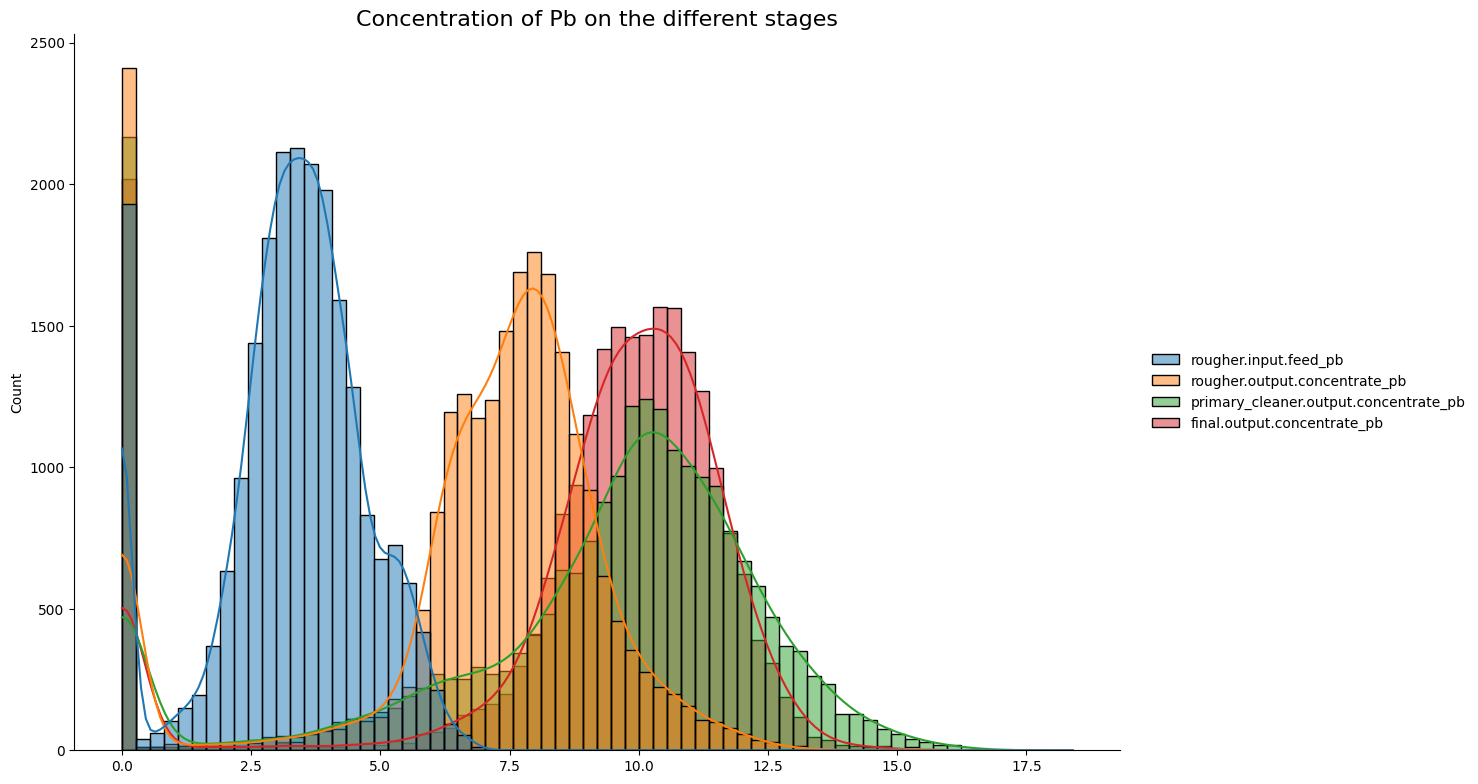

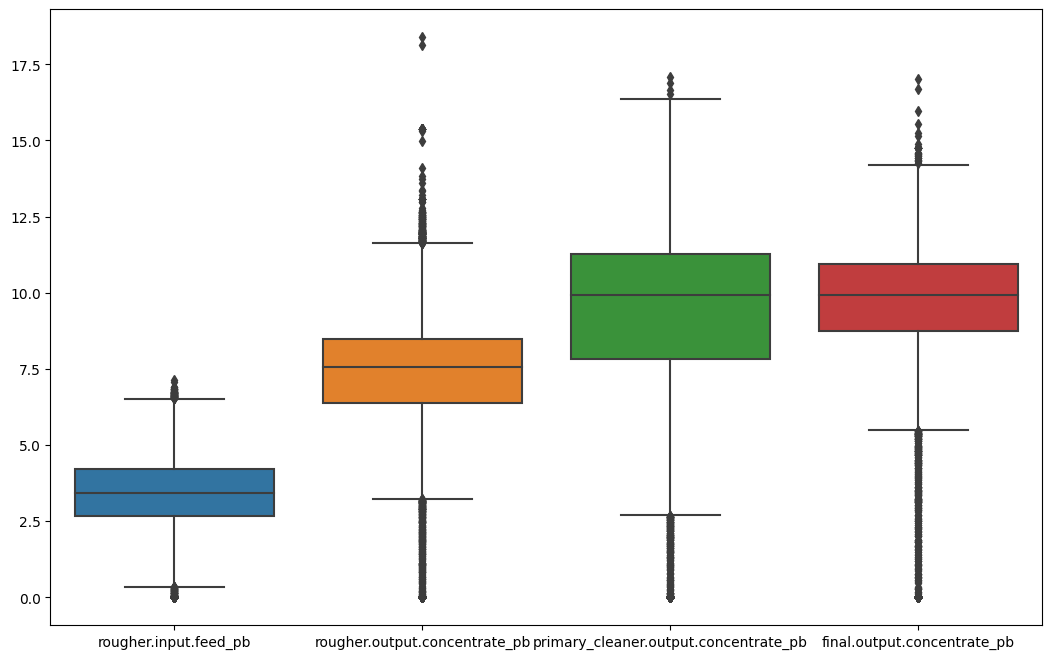

In [87]:
concentrate(elements['lead'])

The concentration of lead gradually increases during the 1st 3 stages of purification. Least of all, lead at the start of the process, when it is mixed with gold-bearing ore. The median indicator almost goes hand in had at the last two stages, but the spread of the values decreases at the final stage. More outliers as well.

Comparing the feed particle size distributions in training set and test set. 

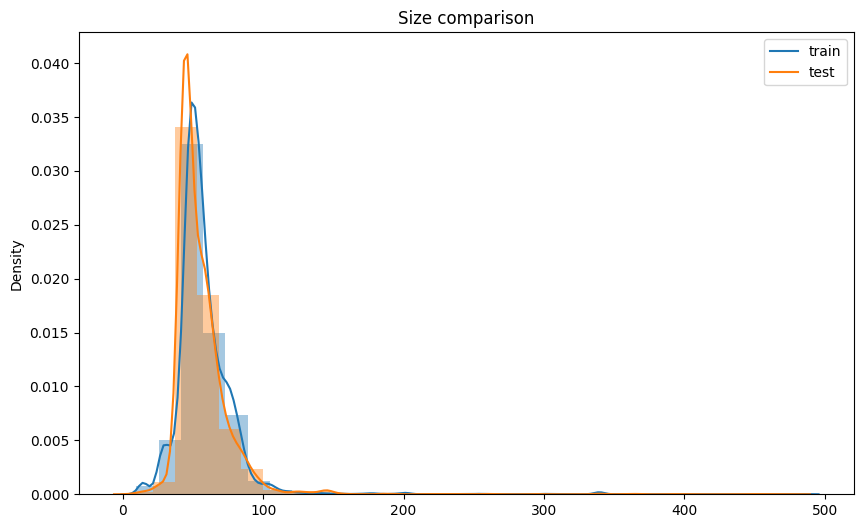

In [88]:
rougher_train_concentration = train_df[train_df['rougher.input.feed_size'] > 1]
rougher_test_concentration = test_df[test_df['rougher.input.feed_size'] > 1]
    
plt.figure(figsize=(10, 6))
sns.distplot(rougher_train_concentration[['rougher.input.feed_size']], bins=30)
sns.distplot(rougher_test_concentration[['rougher.input.feed_size']], bins=30)
plt.legend(['train', 'test'])
plt.title('Size comparison')
plt.show()

The distribution sizees seem to be different slightly. We can see that the test sample is dominated by larger granules.

## Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

In [89]:
first = 'rougher.input.feed_'
second = 'rougher.output.concentrate_'
third = 'primary_cleaner.output.concentrate_'
fourth = 'final.output.concentrate_'

In [90]:
full_df['raw_material'] = full_df[[first+'au', first+'ag', first+'pb']].sum(axis=1)
full_df['draft_concentrate'] = full_df[[second+'au', second+'ag', second+'pb']].sum(axis=1)
full_df['concentrate_after_filtering'] = full_df[[third+'au', third+'ag', third+'pb']].sum(axis=1)
full_df['final_concentrate'] = full_df[[fourth+'au', fourth+'ag', fourth+'pb']].sum(axis=1)

In [91]:
full_df[['raw_material', 'draft_concentrate', 'concentrate_after_filtering', 'final_concentrate']].describe()

,raw_material,draft_concentrate,concentrate_after_filtering,final_concentrate
count,22716.000000,22716.000000,22716.000000,22716.000000
mean,18.833952,35.500849,45.489901,53.673032
std,7.418530,13.401008,16.248774,17.975586
min,0.000000,0.000000,0.000000,0.000000
25%,16.447446,37.326591,48.745632,58.684224
50%,19.560398,39.961497,51.517962,60.073814
75%,23.572584,42.181417,53.156499,60.990543
max,35.071987,55.568687,60.269003,65.575259


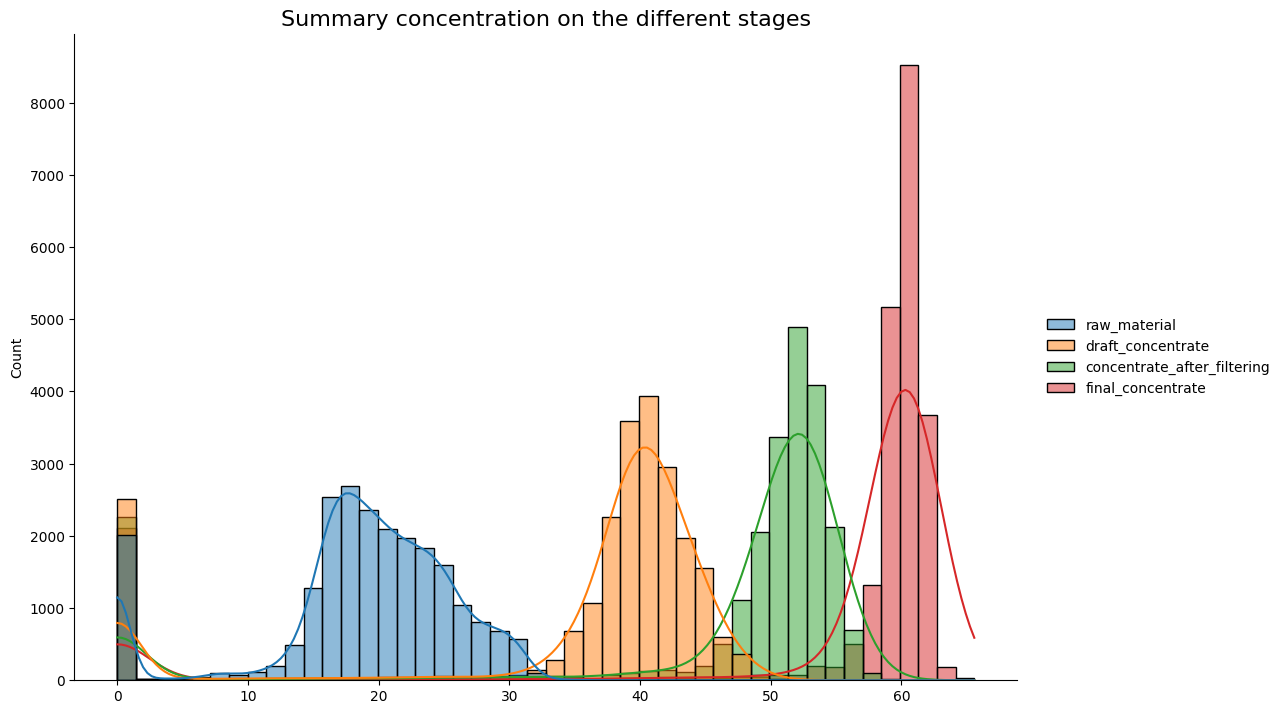

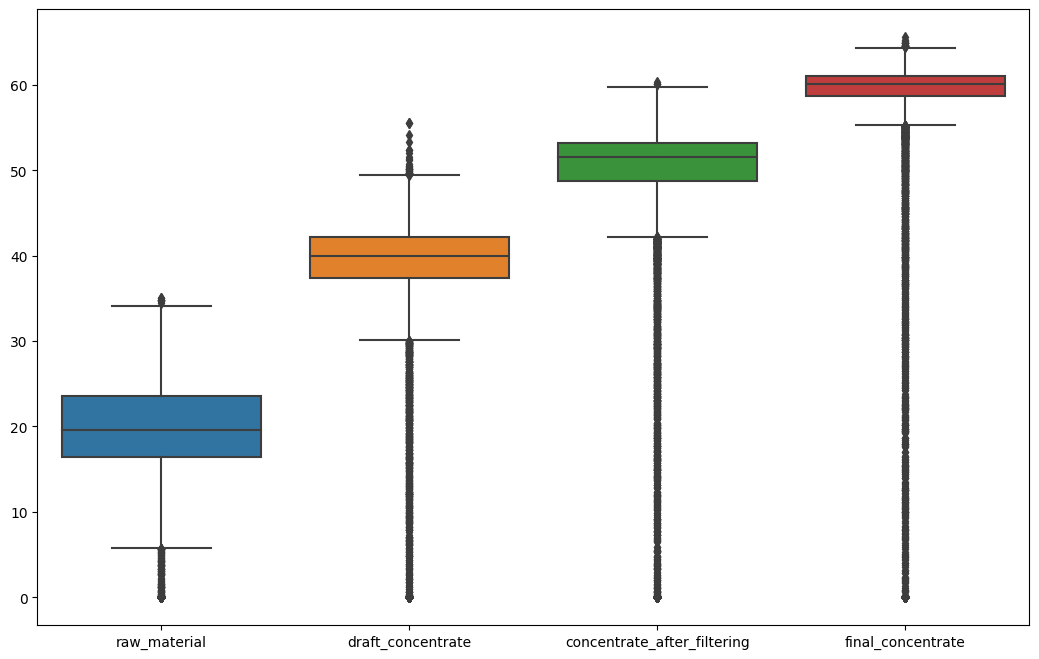

In [92]:
all_col = ['raw_material', 'draft_concentrate', 'concentrate_after_filtering', 'final_concentrate']
concentrate = full_df[all_col]    
    
sns.displot(full_df[all_col], 
            legend=True, 
            kde=True, 
            height=7, 
            aspect=1.5)
    
plt.title('Summary concentration on the different stages', fontsize=16)
    
plt.figure(figsize=(12.8,8))
plt.xticks(rotation=0)
sns.boxplot(data=full_df[all_col])
plt.show()

There a not a lot of 0 value outliers. In the raw, it can be connected with nonmetal materials. They may have an impact on the performance of our models so it is best to just remove them.

In [93]:
for col in all_col:
    print(col, 'zeros:', len(full_df[full_df[col] == 0]))
    print(col, 'under 1:', len(full_df[full_df[col] < 1]))
    print('\n')

raw_material zeros: 1626
raw_material under 1: 2007


draft_concentrate zeros: 2051
draft_concentrate under 1: 2504


concentrate_after_filtering zeros: 1724
concentrate_after_filtering under 1: 2260


final_concentrate zeros: 1699
final_concentrate under 1: 2105




In [94]:
cleaned_full_df = full_df[
    (full_df['raw_material'] >  1) & 
    (full_df['draft_concentrate'] > 1) & 
    (full_df['concentrate_after_filtering'] > 1) & 
    (full_df['final_concentrate'] > 1)
]

cleaned_full_df.shape

(19575, 91)

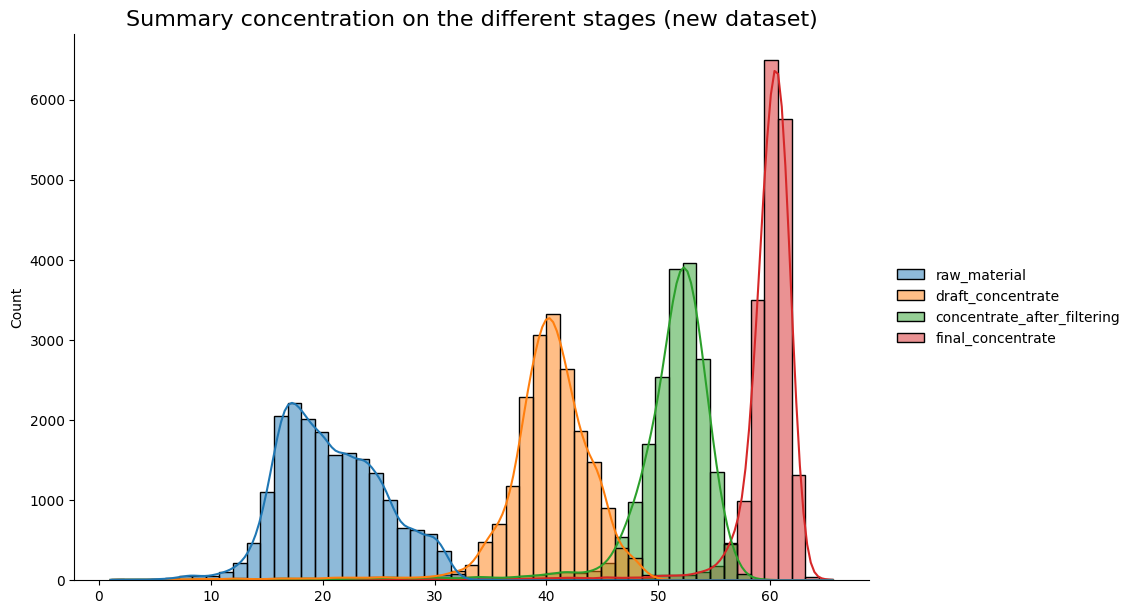

In [95]:
sns.displot(cleaned_full_df[['raw_material', 'draft_concentrate', 
                       'concentrate_after_filtering', 'final_concentrate']], 
            legend=True, 
            kde=True, 
            height=6, 
            aspect=1.5)
plt.title('Summary concentration on the different stages (new dataset)', fontsize=16)
plt.show()

In [96]:
cleaned_full_df[['raw_material', 'draft_concentrate', 'concentrate_after_filtering', 'final_concentrate']].describe()


,raw_material,draft_concentrate,concentrate_after_filtering,final_concentrate
count,19575.000000,19575.000000,19575.000000,19575.000000
mean,20.733002,40.035789,50.757705,59.335867
std,4.637593,4.732761,5.546544,4.992355
min,1.130990,1.137053,1.037408,1.084495
25%,17.250835,38.494072,49.961182,59.235753
50%,20.219502,40.398724,51.853851,60.268208
75%,23.988143,42.493014,53.318204,61.066597
max,35.071987,55.568687,60.106566,65.575259


In [97]:
train_clean = train_df[train_df['date'].isin(cleaned_full_df['date'])]
train_clean.dropna(inplace=True)
print('Train set', train_clean.shape)

Train set (14335, 55)


In [98]:
test_clean = test_df[test_df['date'].isin(cleaned_full_df['date'])]
test_clean.dropna(inplace=True)
print('Test set', test_clean.shape)

Test set (5240, 55)


## Building Models

In [99]:
def total_smape(smape_rougher, smape_final):
    final_result = 0.25 * smape_rougher + 0.75 * smape_final
    return final_result

In [100]:
#training set
target_rougher_train = train_clean['rougher.output.recovery']
target_final_train = train_clean['final.output.recovery']
features_train = train_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

#test set:
target_rougher_test = test_clean['rougher.output.recovery']
target_final_test = test_clean['final.output.recovery']
features_test = test_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

In [101]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [102]:
random_state = 12345
cv = 5
models = [DecisionTreeRegressor(random_state = random_state), 
          RandomForestRegressor(random_state=random_state), 
          LinearRegression()]

In [103]:
#creating a function for sMAPE score:
def smape_scorer(target, predictions):
    smape = ((1 / len(target)) * (abs(target - predictions) / ((abs(target) + abs(predictions)) / 2))).sum() * 100
    return smape

In [105]:
#creating a function for scoring the model:
def fit_and_check(model, params, train_df, df_target):
    my_scorer = make_scorer(smape_scorer, greater_is_better=False)
    clf = GridSearchCV(model, params, scoring=my_scorer, cv=5)
    clf.fit(train_df, df_target)
    
    return clf.best_estimator_, clf.best_score_

In [106]:
results_cross_val = []

for model in models:
    
    scorer = make_scorer(smape_scorer, greater_is_better=False) 
    
    cross_val_score_rougher = cross_val_score(model, 
                                              features_train, 
                                              target_rougher_train, 
                                              cv=cv, scoring=scorer).mean()
    cross_val_score_final = cross_val_score(model, 
                                            features_train, 
                                            target_final_train, 
                                            cv=cv, scoring=scorer).mean()

    results_cross_val.append({'model name': model.__class__.__name__, 
                              'cross_val_score_rougher': cross_val_score_rougher, 
                              'cross_val_score_final': cross_val_score_final}) 
              
pd.DataFrame(results_cross_val)

,model name,cross_val_score_rougher,cross_val_score_final
0,DecisionTreeRegressor,-13.595366,-21.790176
1,RandomForestRegressor,-7.899267,-10.783920
2,LinearRegression,-7.878660,-11.472744


Random forest turns out to be the best model. Let's tune some hyperparamters next.

In [107]:
results = []

for depth in range(1,5):
    
    for estimator in range(10, 21, 5):
        
        model = RandomForestRegressor(random_state=random_state, 
                                       n_estimators=estimator, 
                                       max_depth=depth)
        
        scorer = make_scorer(smape_scorer, greater_is_better=False) 
    
        cross_val_score_rougher = cross_val_score(model, features_train, target_rougher_train, cv=cv, scoring=scorer).mean()
        cross_val_score_final = cross_val_score(model, features_train, target_final_train, cv=cv, scoring=scorer).mean()

        smape_final_result = total_smape(cross_val_score_rougher, cross_val_score_final)

        results.append({'model name': model.__class__.__name__, 
                        'Hyperparameters': {'random_state': random_state, 
                                            'n_estimators': estimator, 
                                            'max_depth':depth}, 
                        'smape_final_result': smape_final_result})

pd.DataFrame(results).style.highlight_max(color = 'lightgreen', axis = 0)

,model name,Hyperparameters,smape_final_result
0,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 10, 'max_depth': 1}",-9.633839
1,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 15, 'max_depth': 1}",-9.633718
2,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 20, 'max_depth': 1}",-9.645140
3,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 10, 'max_depth': 2}",-9.276989
4,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 15, 'max_depth': 2}",-9.232788
5,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 20, 'max_depth': 2}",-9.247567
6,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 10, 'max_depth': 3}",-9.451703
7,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 15, 'max_depth': 3}",-9.399270
8,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 20, 'max_depth': 3}",-9.349372
9,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 10, 'max_depth': 4}",-9.324530


As we see the best scoring has a Random Forest model. After checking it with hyperarameters I found out that the best result showed model with n_estimators=15 and max_depth=4

## Best Model

In [108]:
model_final = RandomForestRegressor(random_state=random_state, 
                                       n_estimators=15, 
                                       max_depth=4)

model_final.fit(features_train, target_rougher_train)
predictions_r = model_final.predict(features_test)

model_final.fit(features_train, target_final_train)
predictions_f = model_final.predict(features_test)

In [109]:
smape_r = smape_scorer(target_rougher_test, predictions_r)
smape_f = smape_scorer(target_final_test, predictions_f)

print('Final sMAPE:', total_smape(smape_r, smape_f))

Final sMAPE: 7.774105909635919


In [110]:
len(train_df) + len(test_df)

22716

In [111]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(features_train, target_rougher_train)
predictions_r_dummy = dummy_regr.predict(features_test)

dummy_regr.fit(features_train, target_final_train)
predictions_f_dummy = dummy_regr.predict(features_test)

In [55]:

smape_r_dummy = smape_scorer(target_rougher_test, predictions_r_dummy)
smape_f_dummy = smape_scorer(target_final_test, predictions_f_dummy)

print('Final sMAPE', total_smape(smape_r_dummy, smape_f_dummy))

Final sMAPE 8.735114730782414


Random Forest still shows best results. The sanity check was also succesful.

## Conclusion

The project's goal of creating a prototype of a machine learning model that can predict the recovery rate of gold from gold ore has been met. The data was processed and analyzed during the project, and a random forest model was built and trained as a result. The final model outperforms the constant model: the trained model's error is 7.7%, while the constant model's error is 7.9%. During the project, the following steps were taken:

read and analyzed the data (prepared an EDA report for each dataset)
data that has been pre-processed (processing missing values, replacing data type, checking for duplicates)
double-checked the enrichment efficiency calculation.
investigated how metal concentrations (Au, Ag, Pb) change during the purification process. We can conclude that the concentration of each metal varies depending on the stage of purification: gold concentration gradually increases with each stage, silver concentration decreases, and lead concentration increases in the first three stages.
performed a granule size analysis on the training and test sets to ensure that the granule sizes are roughly evenly distributed in the training and test sets.
examined the total concentration of all metals at various stages, identifying and removing anomalies (a large number of zeros) from all datasets.
created functions to compute sMAPE and final sMAPE
compared the performance of various models (DecisionTreeRegressor (), RandomForestRegressor, LinearRegression) and how the best random forest model was selected using the hyperparameters n estimators = 15 and max depth = 4. The final model's work was tested on a test sample, and it performed well: the trained model's error is 7.7%, while the constant error is 7.9%.